# 03: Time Series

Much of climate science centers on time series analysis, particular in evaluations of climate change. The [xarray](https://xarray.pydata.org) module and its extensions provide many useful tools for working with the time evolution of climate variables and geospatial fields. This tutorial focuses on time series of climate variables.  

In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import colormaps

And read in the same data file:

In [2]:
aod = xr.open_dataset('./data/od550aer_mon_historical_HadGEM3-GC31-LL_1850-2014.2p5.ens_5mem.nc')['od550aer']

To extract a time series from a lat-lon-time grid, we can use xarray's selection methods.
- [Time series in xarray](https://docs.xarray.dev/en/stable/user-guide/time-series.html)
- [Indexing and selecting data in xarray](https://docs.xarray.dev/en/stable/user-guide/indexing.html)

Here I've selected the time series closest to [Bali](https://en.wikipedia.org/wiki/Bali). 

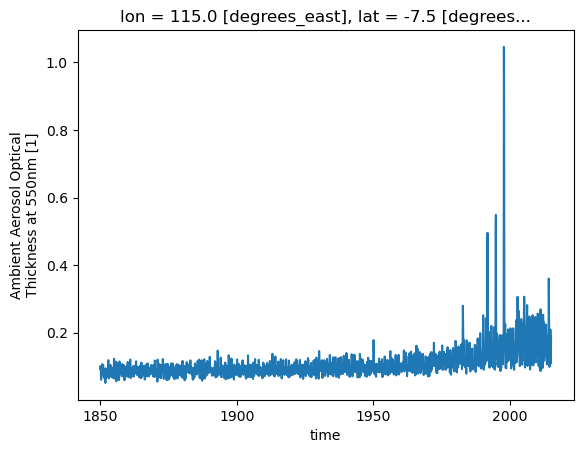

In [3]:
aodts = aod.sel(lat=-7.5, lon=115)
aodts.isel(record=0).plot()

Although the main features of the AOD increase in time are evident in this plot, we can again improve on the presentation. For example, using groupby we can compute the time series of annual means to reduce the month-to-month noise:

In [4]:
aod_yr = aodts.groupby('time.year').mean('time')

And plot the time series for each ensemble member to see how similar they are. In this model, aerosols 

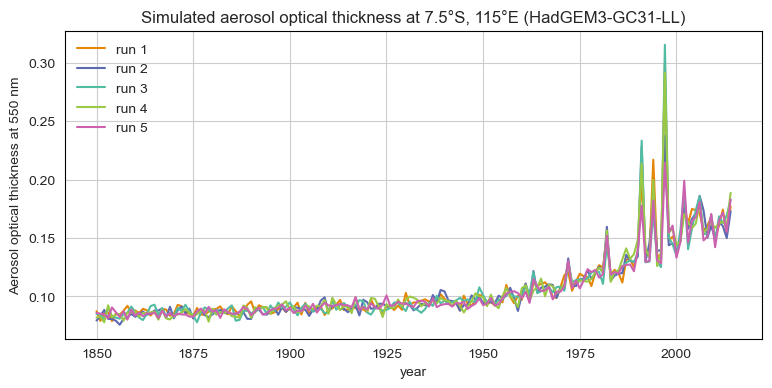

In [5]:
clrs = colormaps.vivid.colors

sns.set_style('whitegrid', {"axes.edgecolor": "k"})

fig = plt.figure(figsize=(9,4))
axs = fig.add_subplot(111)

aod_yr.isel(record=0).plot(color=clrs[0], label='run 1')
aod_yr.isel(record=1).plot(color=clrs[1], label='run 2')
aod_yr.isel(record=2).plot(color=clrs[2], label='run 3')
aod_yr.isel(record=3).plot(color=clrs[3], label='run 4')
aod_yr.isel(record=4).plot(color=clrs[4], label='run 5')

axs.set_ylabel('Aerosol optical thickness at 550 nm')
axs.set_title('Simulated aerosol optical thickness at 7.5°S, 115°E (HadGEM3-GC31-LL)')
axs.legend(frameon=False, loc='upper left')

plt.show()
plt.close(fig)

In computing anomalies, we often need to account for the seasonal cycle. There are two ways we can do this:

1. Average each year, leaving only annual means, and then subtract the time mean
2. Subtract the long-term mean for each month, leaving all months

Fortunately, xarray makes both of these remarkably easy. 

- [Grouping in xarray](https://docs.xarray.dev/en/stable/user-guide/groupby.html)

In [6]:
# Annual mean anomalies
aoda = aodts.isel(record=2).groupby('time.year').mean('time') - aodts.isel(record=2).mean('time')

# Anomaly from mean annual cycle
aods = aodts.isel(record=2).groupby('time.month') - aodts.isel(record=2).groupby('time.month').mean('time')

With a little manipulation, we can make even more types of statistical plots. 

- [seaborn example gallery](https://seaborn.pydata.org/examples/index.html) 

Here we define a new coordinate that indicates the decade of the monthly anomaly and use this to create a categorical plot.

- [Reshaping and reorganizing in xarray](https://docs.xarray.dev/en/stable/user-guide/reshaping.html)

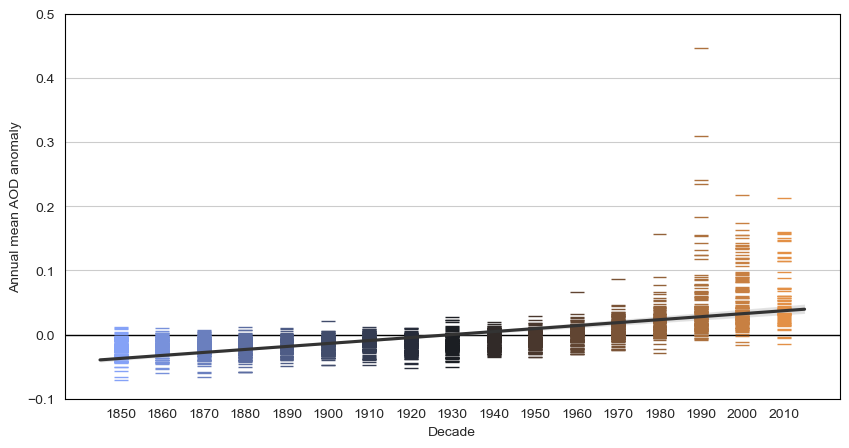

In [7]:

# Sort by decade
year = aods['time'].dt.year.values
dcde = 1850 + 10*((year - year[0]) / 10).astype(int)
aod_dec = aods.assign_coords({'decade': ('time', dcde)})
# Now we can group by decade -- uncomment below to see the result
# print(dec_tas['decade'])

# Plot preliminaries
sns.set_style('whitegrid', {"axes.edgecolor": "k"})
clrs = colormaps.orangeblue_dark_r.discrete(17) # read in 17 colors from the map
fig, axs = plt.subplots(figsize=(10,5))

# Plotting
axs.axhline(0, color='k', linewidth=1, zorder=1)
sns.stripplot(ax=axs, x=aod_dec['decade'], y=aod_dec.values, hue=aod_dec['decade'], palette=clrs, legend=False, 
              jitter=False, s=10, marker='_', linewidth=1)
sns.regplot(ax=axs, x=np.linspace(-0.5,16.5, 1980), y=aods.values, color='#333', scatter=False, ci=99, line_kws={'zorder': 10})
axs.set_ylim((-0.1, 0.5))
axs.set_ylabel('Annual mean AOD anomaly')
axs.set_xlabel('Decade')
plt.show()

The trend is highly significant confidence level, despite large outliers in recent years. How large is it? Python has many modules for statistical analysis, including some that extend xarray.

- [scipy stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [statsmodels](https://www.statsmodels.org/stable/index.html)
- [scikit-learn](https://scikit-learn.github.io/stable)

Here we use the most accessible, scipy, to calculate the trend based on decadal means, starting from 1940 and ending in 2009 (seven complete decades):

In [8]:
from scipy.stats import linregress
res = linregress(np.arange(7), aod_dec.sel(time=slice('1940','2009')).groupby('decade').mean('time'))
print(res)

LinregressResult(slope=0.012434306685324937, intercept=-0.01892837327018026, rvalue=0.9310540668996161, pvalue=0.0023093677239558984, stderr=0.002179280911142228, intercept_stderr=0.007857509068763185)


This climate model simulation produces a ~0.012±0.004 per decade trend in AOD over 1940-2009. The simple Student's *t* test applied by [scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) indicates that the slope is different from zero at *p* < 0.01. Because the test applied in this case assumes sample independence only at the decadal time scale (a very conservative assumption), we can assign a high level of confidence to the sign of the trend.